In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [0]:
zip_ref = zipfile.ZipFile("/content/drive/My Drive/Machine _Hack/Food_QUalityA_ParticipantsData.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [0]:
train_data = pd.read_excel('/tmp/Food_QUalityA_ParticipantsData/Data_Train.xlsx')
test_data = pd.read_excel('/tmp/Food_QUalityA_ParticipantsData/Data_Test.xlsx')
submission = pd.read_excel('/tmp/Food_QUalityA_ParticipantsData/Sample_Submission.xlsx')

In [35]:
train_data

,ID,Date,LicenseNo,FacilityID,FacilityName,Type,Street,City,State,LocationID,Reason,SectionViolations,RiskLevel,Geo_Loc,Inspection_Results
0,31103489027986,26-04-2010,4744,8123,7715,RESTAURANT,15522,id-11235901,id_1890134,81876.0,CANVASS,33.0,High,locid16406,4
1,10088999935915,21-06-2009,2973,12268,11664,GROCERY STORE,3057,id-11235901,id_1890134,81862.0,COMPLAINT,33.0,High,locid878,4
2,40148966010272,01-05-2013,18223,1112,969,RESTAURANT,14988,id-11235901,id_1890134,81883.0,CANVASS,NaN,High,locid3368,6
3,37157708563676,28-09-2015,20825,20007,19115,RESTAURANT,3661,id-11235901,id_1890134,81859.0,CANVASS RE-INSPECTION,31.0,Medium,locid11839,4
4,47478049564374,09-12-2015,2136,16867,10409,RESTAURANT,7876,id-11235901,id_1890134,81886.0,COMPLAINT,30.0,High,locid12264,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147438,32616888047244,15-06-2015,23001,19617,18736,GROCERY STORE,6229,id-11235901,id_1890134,81873.0,COMPLAINT,3.0,Medium,locid203,1
147439,38335234403261,28-11-2010,35329,21729,20760,RESTAURANT,3697,id-11235901,id_1890134,81848.0,SHORT FORM COMPLAINT,NaN,High,locid7202,4
147440,42693381689429,23-09-2014,5361,12685,12038,RESTAURANT,13027,id-11235901,id_1890134,81877.0,CANVASS,NaN,Medium,locid3614,6
147441,49087006944080,25-01-2018,12338,10898,10324,RESTAURANT,17833,id-11235901,id_1890134,81888.0,CANVASS RE-INSPECTION,3.0,High,locid757,5


In [36]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147443 entries, 0 to 147442
Data columns (total 15 columns):
ID                    147443 non-null int64
Date                  147443 non-null object
LicenseNo             147443 non-null int64
FacilityID            147443 non-null int64
FacilityName          147443 non-null int64
Type                  143958 non-null object
Street                147443 non-null int64
City                  147443 non-null object
State                 147443 non-null object
LocationID            147408 non-null float64
Reason                147443 non-null object
SectionViolations     108375 non-null float64
RiskLevel             147443 non-null object
Geo_Loc               147443 non-null object
Inspection_Results    147443 non-null int64
dtypes: float64(2), int64(6), object(7)
memory usage: 16.9+ MB


In [37]:
train_data.describe()

,ID,LicenseNo,FacilityID,FacilityName,Street,LocationID,SectionViolations,Inspection_Results
count,1.474430e+05,147443.000000,147443.000000,147443.000000,147443.000000,147408.000000,108375.000000,147443.000000
mean,2.997142e+13,17726.613003,14020.779583,13377.891009,8684.119653,81873.642156,24.129153,3.680405
std,1.154808e+13,10865.050018,7794.382869,7408.148606,5255.991577,140.248846,12.657456,1.481441
min,1.000014e+13,0.000000,0.000000,0.000000,0.000000,31259.000000,1.000000,0.000000
25%,1.994861e+13,8588.000000,7347.000000,6993.000000,4109.000000,81859.000000,14.000000,4.000000
50%,2.999146e+13,17056.000000,14256.000000,13710.000000,8541.000000,81870.000000,31.000000,4.000000
75%,3.995723e+13,26163.000000,20841.000000,19795.000000,13321.000000,81888.000000,33.000000,4.000000
max,4.999987e+13,37394.000000,27276.000000,26032.000000,17891.000000,82072.000000,70.000000,6.000000


In [38]:
train_data.corr()

,ID,LicenseNo,FacilityID,FacilityName,Street,LocationID,SectionViolations,Inspection_Results
ID,1.000000,-0.001000,-0.002463,-0.002147,-0.000081,-0.000495,0.001203,-0.006987
LicenseNo,-0.001000,1.000000,0.007651,0.004446,-0.008863,-0.003506,-0.040790,-0.042021
FacilityID,-0.002463,0.007651,1.000000,0.917714,-0.017715,0.002109,0.004258,-0.004908
FacilityName,-0.002147,0.004446,0.917714,1.000000,-0.012873,0.003299,0.004225,-0.004162
Street,-0.000081,-0.008863,-0.017715,-0.012873,1.000000,0.015736,0.006610,-0.004127
LocationID,-0.000495,-0.003506,0.002109,0.003299,0.015736,1.000000,0.007259,-0.001862
SectionViolations,0.001203,-0.040790,0.004258,0.004225,0.006610,0.007259,1.000000,0.250834
Inspection_Results,-0.006987,-0.042021,-0.004908,-0.004162,-0.004127,-0.001862,0.250834,1.000000


In [0]:
train_data = train_data.drop(['ID','LocationID'],axis=1)
test_data = test_data.drop(['ID','LocationID'],axis=1)

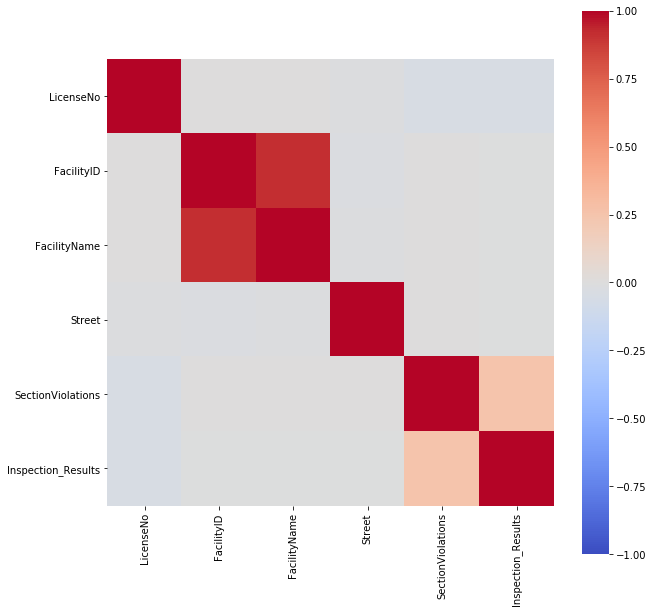

In [40]:
corr = train_data.corr()
plt.figure(figsize=(10,10))
ax = sns.heatmap(corr,vmin=-1, vmax=1, center=0,cmap='coolwarm',square=True)

In [41]:
print(train_data.isnull().sum())
print("***"*20)RESTAURANT
print(test_data.isnull().sum())

Date                      0
LicenseNo                 0
FacilityID                0
FacilityName              0
Type                   3485
Street                    0
City                      0
State                     0
Reason                    0
SectionViolations     39068
RiskLevel                 0
Geo_Loc                   0
Inspection_Results        0
dtype: int64
************************************************************
Date                     0
LicenseNo                0
FacilityID               0
FacilityName             0
Type                  1215
Street                   0
City                     0
State                    0
Reason                   0
SectionViolations    12976
RiskLevel                0
Geo_Loc                  0
dtype: int64


In [43]:
train_data['Type'].mode()[0]

'RESTAURANT'

In [46]:
train_data['SectionViolations'].mean()

24.129153402537487

In [0]:
# train_data = train_data.fillna(method='backfill')
train_data['Type'].replace(np.nan,"RESTAURANT",inplace=True)
test_data['Type'].replace(np.nan,"RESTAURANT",inplace=True)

In [0]:
train_data['SectionViolations'].fillna(train_data['SectionViolations'].mean(),inplace = True)
test_data['SectionViolations'].fillna(test_data['SectionViolations'].mean(),inplace = True)

In [53]:
print(train_data.isnull().sum())
print("***"*20)
print(test_data.isnull().sum())

Date                  0
LicenseNo             0
FacilityID            0
FacilityName          0
Type                  0
Street                0
City                  0
State                 0
Reason                0
SectionViolations     0
RiskLevel             0
Geo_Loc               0
Inspection_Results    0
dtype: int64
************************************************************
Date                 0
LicenseNo            0
FacilityID           0
FacilityName         0
Type                 0
Street               0
City                 0
State                0
Reason               0
SectionViolations    0
RiskLevel            0
Geo_Loc              0
dtype: int64


In [56]:
print(len(train_data))
print(len(test_data))

147443
49148


In [0]:
le = LabelEncoder()